# Dev notebook for updates

`Odd number of sites`

In [1]:
import numpy as np
from dmrg.MPS import MPS 
from dmrg.MPO import MPO_TFI
from dmrg.cont import CONT
from dmrg.dmrg import dmrg
from dmrg.obs import observables

import matplotlib.pyplot as plt

### Class 

In [ ]:
import os
import shutil
import numpy as np

class MPS():
    """
        Class for an Matrix product State
    """

    def __init__(self,L,mem='on',path='MPS',d=2,b_mps1=np.identity(2),b_mps2=None):
        self.L = L
        self.path = path
        self.d = d

        if mem == 'on':
            if os.path.isdir(path):
                shutil.rmtree(path)
            os.mkdir(path)
            os.mkdir(path+'/S')
            for i in range(L):
                open(path+f'/ten_{i}.dat','w')
            self.write(0,b_mps1)
            if b_mps2 == None:
                b_mps2 = b_mps1
            self.write(L-1,b_mps2)
            if L%2 == 1:
                self.write(1,np.reshape(np.identity(4)[:,:2],(2,2,2)))

        if mem == 'off':
            raise ValueError("The option is not available turn the memory on")


    def __str__(self):
        return f'Matrix Product State of a 1 D chain with {self.L} sites'
    
    def __repr__(self):
        return f'Matrix Product State of a 1 D chain with {self.L} sites'


    def write(self,i,ten):
        f1 = np.memmap(self.path+f'/ten_{i}.dat',dtype='complex',mode='w+',shape=ten.shape)
        f1[:] = ten
        with open(self.path+f'/ten_{i}.txt','w') as f2: 
            f2.writelines(repr(ten.shape))
        del f1,f2

    def writeS(self,i,S):
        f1 = np.memmap(self.path+f'/S/{i}-{i+1}.dat',dtype='complex',mode='w+',shape=S.shape)
        f1[:] = S
        with open(self.path+f'/S/{i}-{i+1}.txt','w') as f2: 
            f2.writelines(repr(S.shape))
        del f1,f2
    
    def shape(self,i):
        s = open(self.path+f'/ten_{i}.txt','r')
        return eval(s.read())

    def shapeS(self,i):
        s = open(self.path+f'/S/{i}-{i+1}.txt','r')
        return eval(s.read())

    def read(self,i):
        return np.memmap(self.path+f'/ten_{i}.dat',dtype='complex',mode='r',shape=self.shape(i))
    
    def readS(self,i):
        return np.memmap(self.path+f'/S/{i}-{i+1}.dat',dtype='complex',mode='r',shape=self.shapeS(i))
    
    def write_bound(self,ten_l,ten_r=None):
        if ten_r == None:
            ten_r = ten_l
        self.write(0,ten_l)
        self.write(self.L-1,ten_r)

    def write_left(self,i,mat):
        self.write(i,self.left_ten(mat))

    def write_right(self,i,mat):
        self.write(i,self.right_ten(mat))

    def delete(self,i):
        if os.path.isfile(self.path+f'/S/{i}-{i+1}.dat'):
            os.remove(self.path+f'/S/{i}-{i+1}.dat')
            os.remove(self.path+f'/S/{i}-{i+1}.txt')
            
    def left_ten(self,mat):
        
        d = self.d
        a,b = mat.shape
        ten = np.zeros((d,int(a/d),b),dtype='complex')

        for i0 in range(d):
            for i1 in range(int(a/d)):
                ten[i0,i1,:] = mat[i1*d+i0,:]

        return ten

    
    def right_ten(self,mat):

        d = self.d
        a,b = mat.shape
        ten = np.zeros((d,a,int(b/d)),dtype='complex')

        for i0 in range(d):
            for i2 in range(int(b/2)):
                ten[i0,:,i2] = mat[:,i0*int(b/d)+i2]

        return ten

    def first_sweep(self):
        half_right = [i for i in range(self.L//2 +self.L%2,self.L-2)]
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(half_right+left,['r']*(self.L//2-2)+['l']*(self.L-4))

    def sweep(self):
        right = [i for i in range(2,self.L-2)]
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(right+left,['r']*(self.L-4)+['l']*(self.L-4))

    def right_sweep(self):
        right = [i for i in range(2,self.L-2)]
        return zip(right,['r']*(self.L-4))

    def left_sweep(self):
        left = [self.L-4-i for i in range(self.L-4)]
        return zip(left,['l']*(self.L-4))

    def random(self):
        ten = np.random.random((2,2,2))
        for i in range(1,L-1):
            self.write(i,np.random.random((2,2,2)))
        self.writeS(self.L//2-1+self.L%2,np.identity(2))

In [125]:
import os
import shutil
import numpy as np

class CONT():
    """
    Class that manages and stores in the memory the contractions on a 1 dimnasional MPS:
        Attributes:
            - mps: mps in the class DMRG.MPS
            - H: MPO of the hamiltonian of the class mpo_etc
            - mem: memory option if turned off the contraction are saved in a list (inconvinient and occupies a lot of memory)
            - path: folder path were the contractions are saved
    """

    # dictionary for the direction of the contraction
    dir = {'l':'/LEFT','r':'/RIGHT'}
    count = {'l':0,'r':1}


    def __init__(self,mps,H,mem='on',path='CONT'):
        self.mps = mps
        self.h = H 
        self.L = mps.L
        # build folder structure were tensors are saved
        if mem == 'on':
            self.path = path
            if os.path.isdir(path):
                shutil.rmtree(path)
            os.mkdir(path)
            os.mkdir(path+'/LEFT')
            os.mkdir(path+'/RIGHT')
            for i in range(mps.L - 3):
                open(path+f'/LEFT/cont_{i}.dat','w')
                open(path+f'/RIGHT/cont_{mps.L-i-1}.dat','w')
            
            self.write_boundary()

        if mem == 'off':
            self.LEFT = []
            self.RIGHT = []
            
    # @classmethod

    def write(self,site,ten,dir):
        if dir != 'l' and dir != 'r':
            raise ValueError('the direction needs to be either l or r !!!')

        tenmap = np.memmap(self.path+self.dir[dir]+f'/cont_{site}.dat',dtype='complex',mode='w+',shape=ten.shape)
        tenmap[:] = ten
        with open(self.path+self.dir[dir]+f'/cont_{site}.txt','w') as f:
            f.writelines(repr(ten.shape))
        del tenmap,f

    def shape(self,site,dir):
        s = open(self.path+self.dir[dir]+f'/cont_{site}.txt','r')
        return eval(s.read())

    def read(self,site,dir):
        return np.memmap(self.path+self.dir[dir]+f'/cont_{site}.dat',dtype='complex',mode='r',shape=self.shape(site,dir))

    def add(self,site,dir):
        ten = self.read(site-(-1)**self.count[dir],dir)
        # ten = self.read(site,dir)

        ten = np.tensordot(ten,self.mps.read(site),(0,1+self.count[dir]))
        ten = np.tensordot(ten,self.h.mpo(p=site),([0,2],[2+self.count[dir],0]))
        ten = np.tensordot(ten,np.conj(self.mps.read(site)),([0,2],[1+self.count[dir],0]))

        self.write(site,ten,dir)
        return ten

    def left(self,site):
        """ 
        Contract all the tensors left of site including it 
        """
        h = self.h
        res = np.tensordot(np.tensordot(self.mps.read(0),h.Wl(),(0,0)),np.conj(self.mps.read(0)),(1,0))
        for i in range(1,site+1):
            res = np.tensordot(res,self.mps.read(i),(0,1))
            res = np.tensordot(res,h.mpo(p=i),([0,2],[2,0]))
            res = np.tensordot(res,np.conj(self.mps.read(i)),([0,2],[1,0]))

        return res
    
    def right(self,site):
        """
        Contract all the tensors right of site including it
        """
        h = self.h
        res = np.tensordot(np.tensordot(self.mps.read(self.L-1),h.Wr(),(0,0)),np.conj(self.mps.read(self.L-1)),(1,0))
        for i in range(1,self.L-site):
            res = np.tensordot(res,self.mps.read(self.L-1-i),(0,2))
            res = np.tensordot(res,h.mpo(p=i),([0,2],[3,0]))
            res = np.tensordot(res,np.conj(self.mps.read(self.L-1-i)),([0,2],[2,0]))
        
        return res

    def write_boundary(self):

        for i in range(self.L%2+1):
            ten_l = self.left(i)
            self.write(i,ten_l,'l')

        ten_r = np.tensordot(np.tensordot(self.mps.read(self.L-1),self.h.Wr(),(0,0)),np.conj(self.mps.read(self.L-1)),(1,0))
        self.write(self.L-1,ten_r,'r')
    
    
    
    def env_prep(self,site):
        
        return self.read(site - 1,'l'),self.read(site + 2,'r')

    def random(self):
        for i in range(1,self.L//2):
            self.add(i+self.L%2,'l')
            self.add(self.mps.L-i-1,'r')

In [ ]:
import numpy as np

from dmrg.lanczos import EffH

class dmrg():
    """
        Class that runs the DMRG algorithm on a 1 dimensional system

            Attributes:
                - cont: Class DMRG.contractions
    """

    def __init__(self,cont,chi=100,cut=1e-12):
        self.cont = cont
        self.mps = cont.mps
        self.chi = chi
        self.h = cont.h
        self.L = cont.L
        self.count = cont.count
        self.cut = cut
        self.d = self.mps.d

    
    def infinite(self):

        En = np.zeros(self.L//2-1)
        
        env_left = self.cont.left(self.L%2)
        env_right = self.cont.right(self.L-1)

        for i in range(1,self.mps.L//2):

            H = EffH(env_left,env_right,self.h,site=i)
            En[i-1],grd = H.lanczos_grd()

            mat = np.reshape(grd,(H.c1*H.d,H.d*H.c2))
            l,c,r = np.linalg.svd(mat)

            bound = min(len(c[c>self.cut]),self.chi)
           
            l = l[:,:bound]
            c = c[:bound]
            r = r[:bound,:]

            self.mps.write_left(i+self.L%2,l)
            self.mps.write_right(self.mps.L-i-1,r)
            
            env_left = self.cont.add(i+self.L%2,'l')
            env_right = self.cont.add(self.mps.L-i-1,'r')
            
        self.mps.writeS(i+self.L%2,np.diag(c))

        return En

    def step2sites(self,site,dir,exc='off',stage=None):

        env_left,env_right = self.cont.env_prep(site)
    
        H = EffH(env_left,env_right,self.h,site=site)

        if dir == 'l' or dir == 'bl':
            init_vec = np.tensordot(self.mps.read(site),np.tensordot(self.mps.read(site+1),self.mps.readS(site+1),(2,0)),(2,1))
            init_vec = dmrg.remish(init_vec)
        if dir == 'r' or dir == 'br':
            init_vec = np.tensordot(np.tensordot(self.mps.readS(site-1),self.mps.read(site),(0,1)),self.mps.read(site+1),(2,1))

        init_vec = np.reshape(init_vec,np.prod(init_vec.shape))

        # En_pre = np.conj(init_vec)@H.matvec(init_vec)
        
        if stage == None:
            En,grd = H.lanczos_grd(psi0=None,exc=exc)
            grd_state = 1/np.sqrt(np.conj(grd)@grd)*grd
        if stage == 'Final':
            grd_state = 1/np.sqrt(init_vec@np.conj(init_vec))*init_vec
            En = np.conj(grd_state)@H.matvec(grd_state)
        
        grd_state = np.reshape(grd_state,(H.c1*H.d,H.d*H.c2))

        l,c,r = np.linalg.svd(grd_state,full_matrices=False)
        
        bound = min(len(c[c>self.cut]),self.chi)
        l = l[:,:bound]
        c = c[:bound]
        r = r[:bound,:]
        
        self.mps.write_left(site,l)
        self.mps.write_right(site+1,r)
        self.mps.writeS(site,np.diag(c))

        if dir == 'r':
            self.cont.add(site,'l')
            if site == self.L -3:
                self.cont.add(site+1,'r')
        
        if dir == 'l':
            self.cont.add(site+1,'r')
            if site == 1:
                self.cont.add(site,'l')
        
        return En, -c**2@np.log(c**2)


    def remish(ten):
        d0,d1,d2,d3 = ten.shape
        res = np.zeros((d1,d0,d2,d3),dtype='complex')
        for i0 in range(d0):
            for i1 in range(d1):
                res[i1,i0,:,:] = ten[i0,i1,:,:]

        return res
    

### Test

100
[-24.58530897 -27.11809106 -29.65815526 -32.20078836 -34.74456292
 -37.28890999 -39.83356578 -42.37839569 -44.9233265  -47.4683165
 -50.01334117 -52.5583858  -55.10344146 -57.64850269 -60.19356619
 -62.73862997 -65.2836929  -67.82875437 -70.37381409]


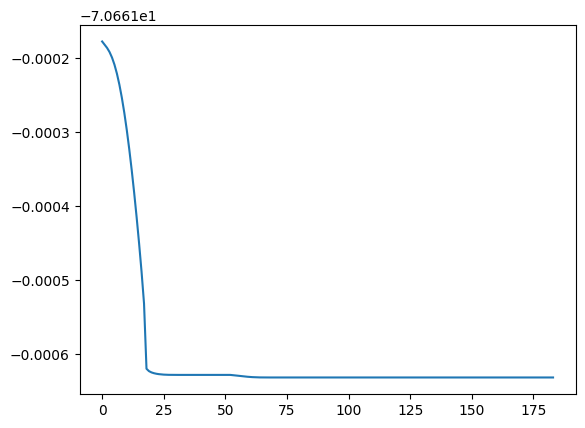

In [10]:
L = 41
mps = MPS(L)
h = MPO_TFI(1,1,pol='tot')
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2)
obs = observables(mps)
En0 = sys.infinite()
# mps.random()
# cont.random()


sys.chi = 100
print(sys.chi)
EE = []
# EE.append(En0[-1])
EE_pre = []
k = 0 
print(En0)

for site,dir in mps.first_sweep():
    En,_ = sys.step2sites(site,dir=dir)
    # EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

Z = []
for i in range(2,L-2):
    En_fin,_ =sys.step2sites(i,dir='r',stage='Final')
    EE.append(En)
    
    Z += [obs.single_site(i,h.Z).real]

plt.plot(EE[1:])

In [14]:
from itertools import product
dim = [2,2,4]
Id4 = np.identity(4)
res = np.zeros((2,2,4))
ranges = [range(d) for d in dim]
for i in product(*ranges):
    res[i[0],i[1],i[2]] =Id4[i[0]*2+i[1],i[2]]